In [1]:
import sys
sys.path.append('/mnt/disk01/note/workspaces/duxinxian')
import pandas as pd
import numpy as np
import os
import datetime
import scorecardpy as sc
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from unity import feature_selector as fs
from unity.fea_eda_func import FeaEdaFunc

In [2]:
cust_main = pd.read_csv('data/sxd_cust_tag.csv')

In [3]:
cust_main['obs_dt'] = cust_main['obs_dt'].astype(str)

## 1.专家特征处理匹配

In [ ]:
edf = pd.read_excel('data/eprt_fea/sxd_zj.xlsx')

In [704]:
ind = pd.read_excel('data/eprt_fea/东方微银贷后指标.xlsx')

In [705]:
cus_busid = pd.read_csv('data/cust_busid.csv')

In [706]:
cus_busid.head()

,req_id,customerid,businessid
0,12021063017581003436,4500413770,TCL20210600002432
1,12021063017491003435,4500413879,TCL20210600002437
2,12021063016071003421,4500413413,TCL20210600002418
3,12021063013581003370,3000780287,TCL20210600002398
4,12021063017291003433,4500413822,TCL20210600002436


In [675]:
edf.head()

,businessid,WN_BNK001,WN_BNK007,WN_BNK033,WN_BNK043,warn_month,WN_ECR075,WN_ECR011,WN_ECR028,WN_ECR038,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
0,TCL20180900000092,0,0,0,0,2018-10-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCL20180900000092,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCL20180900000145,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCL20180900000145,0,0,0,0,2018-12-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCL20180900000145,0,0,0,0,2019-01-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [676]:
edf['warn_month'] = edf['warn_month'].astype('datetime64[ns]')

In [4]:
cust_main['obj_date'] = pd.to_datetime(cust_main['obs_dt'], format='%Y%m%d')
cust_main['cust_no'] = cust_main['cust_no'].astype(str)
cust_main = cust_main.sort_values(['cust_no','obj_date'])

In [678]:
cus_busid = cus_busid.rename({'customerid':'cust_no'},axis=1)
cus_busid['cust_no'] = cus_busid['cust_no'].astype(str)

In [679]:
edf = cus_busid.merge(edf)
edf = edf.rename({'warn_month':'obj_date'},axis=1)
edf = edf.sort_values(['cust_no','obj_date'])
# edf['obs_dt'] = edf['obj_date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [680]:
edf['p'] = 0
edf.loc[edf['obj_date'] <= '2019-12-31','p'] = 1
edf.loc[(edf['obj_date'] > '2019-12-31')&(edf['obj_date'] <= '2020-03-31'),'p'] = 2
edf.loc[(edf['obj_date'] > '2020-03-31')&(edf['obj_date'] <= '2020-06-30'),'p'] = 3
edf = edf[edf['p'] != 0]

In [681]:
edfp = edf.groupby(['cust_no','p']).last().reset_index()

In [682]:
cust_main['p'] = 0
cust_main.loc[cust_main['obj_date'] == '2019-12-31','p'] = 1
cust_main.loc[cust_main['obj_date'] == '2020-03-31','p'] = 2
cust_main.loc[cust_main['obj_date'] == '2020-06-30','p'] = 3

In [683]:
main_df = cust_main.merge(edfp.loc[:, ~edfp.columns.str.contains('obs_dt|obj_date')],on=['cust_no','p'],how='left')

In [684]:
# TODO:专家特征匹配缺失,cm_retail_lon_acct合同号（cont_no）与进件中的businessid是一个字段

In [685]:
main_df[main_df['businessid'].isnull()]

,cust_no,obs_dt,tag,obj_date,p,req_id,businessid,WN_BNK001,WN_BNK007,WN_BNK033,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
55,3000195780,20191231,0,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,3000195780,20200331,0,2020-03-31,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.行为特征匹配

In [5]:
xw1 = pd.read_csv('data/bhv_fea/sxd_xw_1.csv')
xw2 = pd.read_csv('data/bhv_fea/sxd_xw_2.csv')
xw1.loc[:,['cust_no','obs_dt']] = xw1.loc[:,['cust_no','obs_dt']].astype(str)
xw2.loc[:,['cust_no','obj_date']] = xw2.loc[:,['cust_no','obj_date']].astype(str)

In [6]:
xw2.rename({'obj_date':'obs_dt'},axis=1,inplace=True)

In [8]:
main_df = main_df.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
main_df = main_df.merge(xw2,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw2,on=['cust_no','obs_dt'],how = 'left')

In [689]:
# null_cnt = main_df.isnull().sum()/4189
# null_cnt[null_cnt>0.5]

In [9]:
main_df.head()

,cust_no,obs_dt,tag,obj_date,dubil_num_3,dubil_num_6,dubil_num_9,dubil_num_12,count_loan_3,count_loan_6,...,sum_normalpayoff_amt_rate_3,count_ovduepayoff_loan_rate_12,count_ovduepayoff_loan_rate_9,count_ovduepayoff_loan_rate_6,count_ovduepayoff_loan_rate_3,sum_ovduepayoff_amt_rate_12,sum_ovduepayoff_amt_rate_9,sum_ovduepayoff_amt_rate_6,sum_ovduepayoff_amt_rate_3,Unnamed: 106
0,1000000723,20200630,0,2020-06-30,644.0,757.0,757.0,757.0,644.0,757.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1000024521,20191231,0,2019-12-31,93.0,185.0,238.0,238.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000024521,20200331,0,2020-03-31,92.0,184.0,276.0,329.0,92.0,184.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3000010470,20191231,0,2019-12-31,93.0,185.0,276.0,344.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000042033,20191231,0,2019-12-31,93.0,100.0,100.0,100.0,93.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.征信特征匹配

In [10]:
zxfea = pd.read_csv('data/zxfea.csv')
zxvar = pd.read_csv('data/zxfea_var.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2087,2088,2089,2090,2091,2093,2094,2095,2096,2097,2098,2100,2101,2102,2103,2104,2105,2106,2109,2110,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
zxvar['var'] = zxvar['var'].str.lower()

In [12]:
zxfea = zxfea.rename({'customer_no':'cust_no'},axis=1).drop(['tag','rn1','id_no','product_code','biz_date'],axis=1)

In [13]:
zxfeas_set = set(zxfea.columns) & set(zxvar['var'])
zxfeas_set = zxfeas_set | {'cust_no','obs_dt'}

In [14]:
zxfea = zxfea[zxfeas_set]
zxfea.loc[:,['cust_no','obs_dt']] = zxfea.loc[:,['cust_no','obs_dt']].astype(str)

In [15]:
main_df = main_df.merge(zxfea,on=['cust_no','obs_dt'])

In [17]:
main_df = main_df.drop(['label_1m','label'],axis=1)

In [18]:
fea_types = main_df.dtypes
fea_types[fea_types == 'object']

cust_no            object
obs_dt             object
zxbiqryorg         object
zxbilhmph          object
zxbilresaddr       object
zxbilempname       object
zxbigdr            object
zxbiedulvl         object
zxbilproftle       object
zxbipermresaddr    object
zxbilposi          object
zxbicontaddr       object
zxbilindus         object
zxbilrescond       object
zxbilempaddr       object
zxbimarst          object
zxbiqryrea         object
zxbiedudeg         object
dtype: object

In [19]:
main_df.to_csv('main_df_drop_zj.csv',index=False)

## 3.特征工程

### 3.1 数据清洗-剔除单一特征与缺失率超过0.7的特征

In [20]:
# main_df = pd.read_csv('main_df.csv')
main_df = pd.read_csv('main_df_drop_zj.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (114) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
main_df = main_df.replace([-9988,-9989],np.nan)

In [22]:
fsc = fs.FeatureSelector(main_df,labels='tag')

In [23]:
fsc.identify_missing(0.7)
fsc.identify_single_unique()
# fsc.identify_collinear(0.9)

300 features with greater than 0.70 missing values.

28 features with a single unique value.



In [24]:
remove_feas = fsc.check_removal()

Total of 301 features identified for removal


In [25]:
main_df = main_df.drop(remove_feas,axis=1)

In [26]:
train_set = main_df[main_df['obj_date'] != '2020-06-30']
oot_set = main_df[main_df['obj_date'] == '2020-06-30']

In [27]:
train_set['tag'].value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [28]:
oot_set['tag'].value_counts()

0    1312
1     148
Name: tag, dtype: int64

In [29]:
train_set['tag'].value_counts()/len(train_set)

0    0.90005
1    0.09995
Name: tag, dtype: float64

In [31]:
# 包括专家特征
# train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
# oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
# 不包括专家特征
train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date'],axis=1)
oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date'],axis=1)

### 3.2 类别变量处理

In [32]:
from unity.eda_func import EdaFunc

In [33]:
# train_set['dubil_num_3'].astype(float)

In [34]:
fea_types = train_set.dtypes
fea_types[fea_types == 'object']

Series([], dtype: object)

In [647]:
# 包括专家特征
# train_set['area'] = train_set['area'].replace({'上海':1,'厦门':2,'福建':3})
# oot_set['area'] = oot_set['area'].replace({'上海':1,'厦门':2,'福建':3})

In [35]:
# 包括专家特征
# unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
#                'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
#                'zxgcsste','WN_ICR022', 'WN_ICR040', 'WN_LEG039', 'WN_LEG033', 'warn_state']
# train_set = train_set.drop(unique_feas,axis=1)
# oot_set = oot_set.drop(unique_feas,axis=1)
# 不包括专家特征
unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
               'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
               'zxgcsste']
train_set = train_set.drop(unique_feas,axis=1)
oot_set = oot_set.drop(unique_feas,axis=1)

In [36]:
train_set.shape

(2001, 148)

In [37]:
oot_set.shape

(1460, 148)

### 3.3 划分样本

In [38]:
tra_x,tst_x,tra_y,tst_y = train_test_split(train_set,train_set['tag'],shuffle=True,test_size=0.3,random_state=2)
oot_x = oot_set.copy()
oot_y = oot_set['tag']

In [39]:
tra_y.value_counts()

0    1253
1     147
Name: tag, dtype: int64

In [40]:
tst_y.value_counts()

0    548
1     53
Name: tag, dtype: int64

* <font size=4 color=red face=仿宋>直接先用树模型筛选特征</font>

In [41]:
# 包括专家特征
# cat_feas = ['WN_BNK007','WN_TAX008','tag']
# tra_x = tra_x.drop(cat_feas,axis=1)
# tst_x = tst_x.drop(cat_feas,axis=1)
# oot_x = oot_x.drop(cat_feas,axis=1)
# 不包括专家特征
cat_feas = ['tag']
tra_x = tra_x.drop(cat_feas,axis=1)
tst_x = tst_x.drop(cat_feas,axis=1)
oot_x = oot_x.drop(cat_feas,axis=1)

In [655]:
# tra_x = tra_x.apply(lambda x:x.fillna(x.median()))
# tst_x = tst_x.apply(lambda x:x.fillna(x.median()))
# oot_x = oot_x.apply(lambda x:x.fillna(x.median()))

# tra_x = tra_x.apply(lambda x:x.replace({np.inf:x.median()}))
# tst_x = tst_x.apply(lambda x:x.replace({np.inf:x.median()}))
# oot_x = oot_x.apply(lambda x:x.replace({np.inf:x.median()}))

#### 交叉验证筛选特征

In [656]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2)

In [657]:
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = RandomForestClassifier(random_state=2)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [42]:
# tra_x = tra_x.drop('tag',axis=1)
# tst_x = tst_x.drop('tag',axis=1)
clf = LGBMClassifier(random_state=2,class_weight='balanced')
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(30).index)

In [43]:
tra_x = tra_x[sele]
tst_x = tst_x[sele]
oot_x = oot_x[sele]

In [660]:
# tra_x = tra_x.drop(hcorr_lis,axis=1)
# tst_x = tst_x.drop(hcorr_lis,axis=1)
# oot_x = oot_x.drop(hcorr_lis,axis=1)

In [661]:
# clf.fit(tra_x,tra_y)
# tra_pred_y = clf.predict_proba(tra_x)[:,1]
# tst_pred_y = clf.predict_proba(tst_x)[:,1]
# oot_pred_y = clf.predict_proba(oot_x)[:,1]

In [662]:
# sc.perf_eva(tra_y,tra_pred_y)   

In [663]:
# sc.perf_eva(tst_y,tst_pred_y)   

In [664]:
# sc.perf_eva(oot_y,oot_pred_y)    

### 3.3 决策树分箱

In [44]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
tst_x = pd.concat([tst_x,tst_y],axis=1)
oot_x = pd.concat([oot_x,oot_y],axis=1)

In [45]:
bins_dic  =sc.woebin(tra_x,y='tag',method='tree')

[INFO] creating woe binning ...


### 3.4 剔除iv < 0.05的特征

In [46]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)

In [47]:
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
zxysavgloanbalanceamt,False,0.340203
zxcrdpctrmbcurccpr,False,0.262416
zxnmlccusedamt,False,0.214354
lon_amt_12,False,0.208795
zxutpggt6uplpr,False,0.187245
zxcaavgstrmbcurccpr,False,0.185849
zxracallpr,False,0.160976
zxshdpallcurccpr,False,0.158945
rh_tot_card_max_balance_m24,False,0.156735


In [48]:
# bins_dic['WN_ICR043']

In [49]:
# sc.woebin_plot(bins_dic,x=['WN_ICR043','WN_ICR120','WN_TAX017','WN_TAX019','WN_TAX024'])

In [537]:
# adj_bin = sc.woebin(tra_x,x=['WN_ICR043'],y='tag',breaks_list={'WN_ICR043':[1,4,9],'WN_ICR043':[1,4,9]})

[INFO] creating woe binning ...


inf

In [260]:
# sc.woebin_plot(bins_dic,x=['sum_nopayoff_amt_loan_rate_12','sum_nopayoff_amt_loan_rate_6','sum_nopayoff_amt_loan_rate_3',
#                            'count_nopayoff_loan_rate_6','count_payoff_loan_12','zxcaminstallcuraccpr'])

In [500]:
ivdrop_feas = fea_info[fea_info['iv'] < 0.1].index.to_list()

In [501]:
tra_x = tra_x.drop(ivdrop_feas,axis=1)
tst_x = tst_x.drop(ivdrop_feas,axis=1)
oot_x = oot_x.drop(ivdrop_feas,axis=1)

### 3.5 woe

In [502]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
oot_x_woe = sc.woebin_ply(oot_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


### 3.6 剔除psi大于0.1的特征

In [503]:
tst_bin_group = FeaEdaFunc.bin_group(tst_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')
oot_bin_group = FeaEdaFunc.bin_group(oot_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')

In [504]:
def calc_psi(train_bin_dicts,test_bin_dicts):
    """
    根据分箱后的结果计算PSI
    test_bin_dicts 为woe后的结果
    """
    psi_dict = {}
    for k,te in test_bin_dicts.items():
        if 'woe' in k:
            k = k.split('_woe')[0]
            te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
            tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
        else:
            te = te.set_index(k)
            tr = train_bin_dicts[k].set_index(k)
        pair = pd.concat([te['count_distr'],tr['count_distr']],axis=1,keys=['test','train'])
        psi = sum(((pair['test']-pair['train'])*(np.log(pair['test']/pair['train']))).dropna())
        psi_dict[k] = psi
    return psi_dict

In [505]:
psi_info1 = calc_psi(bins_dic,tst_bin_group)
psi_info2 = calc_psi(bins_dic,oot_bin_group)

In [506]:
psi_df1 = pd.DataFrame(psi_info1,index=['psi']).T.sort_values('psi',ascending=False)
psi_df2 = pd.DataFrame(psi_info2,index=['psi']).T.sort_values('psi',ascending=False)

In [508]:
psi_drop1 = set(psi_df1[psi_df1['psi']>0.1].index)
psi_drop2 = set(psi_df2[psi_df2['psi']>0.1].index)
psi_drop = psi_drop1 | psi_drop2

In [509]:
psi_drop = [i+'_woe' for i in psi_drop]

In [510]:
psi_drop

['WN_TAX030_woe', 'WN_TAX029_woe', 'WN_TAX026_woe', 'WN_TAX017_woe']

### 3.7 共线性剔除 

In [579]:
tra_x_woe.corr().style.background_gradient()

,WN_TAX019_woe,WN_TAX027_woe,WN_TAX011_woe,WN_ICR043_woe,WN_ICR120_woe,rh_clear_loan_num_m24_woe,zxutpggt6uplpr_woe,zxactpccnrmaxgtu_woe,WN_MIX017_woe,rh_tot_card_max_balance_m24_woe,zxnmlccusedamt_woe,WN_TAX016_woe,WN_TAX024_woe,WN_MIX027_woe,zxpayamtminstallcurplpr_woe,zxysavgloanbalanceamt_woe,zxcrdpctallcurccpr_woe,WN_TAX015_woe,zxshdprmbcuraccpr_woe,rh_tot_card_amt_m12_woe,WN_TAX025_woe
WN_TAX019_woe,1.000000,0.445282,0.077088,0.033085,0.034105,0.047708,0.061127,0.035889,0.035408,-0.000002,0.008139,0.158125,0.095233,0.319173,0.003045,0.079378,-0.022216,0.213620,0.021535,0.007929,0.111946
WN_TAX027_woe,0.445282,1.000000,0.062142,0.048659,0.067233,0.014035,0.059324,0.022922,-0.068044,0.043103,0.034876,0.053440,0.132260,0.235004,0.023970,-0.000326,-0.003253,0.110108,0.011842,0.041024,0.101141
WN_TAX011_woe,0.077088,0.062142,1.000000,-0.047642,-0.065422,0.026870,0.036334,0.048067,0.142979,0.030967,0.040843,0.034347,0.011959,0.186988,0.101314,0.157228,0.026328,-0.058253,0.054470,-0.001728,0.110829
WN_ICR043_woe,0.033085,0.048659,-0.047642,1.000000,0.761750,0.005558,0.163952,0.175563,0.038825,0.049677,-0.056279,-0.014659,0.005159,0.078928,0.074214,-0.007504,0.150997,0.013429,0.130744,-0.019358,0.038972
WN_ICR120_woe,0.034105,0.067233,-0.065422,0.761750,1.000000,-0.013208,0.182299,0.174574,-0.006185,0.047999,-0.041848,-0.021354,-0.012090,0.070544,0.061718,-0.008903,0.155033,0.007870,0.129505,-0.004124,-0.003733
rh_clear_loan_num_m24_woe,0.047708,0.014035,0.026870,0.005558,-0.013208,1.000000,0.000460,0.030025,-0.005779,-0.034783,0.001505,-0.007314,-0.014458,0.003803,-0.020553,-0.015455,0.051879,-0.019364,0.015762,-0.012236,0.015035
zxutpggt6uplpr_woe,0.061127,0.059324,0.036334,0.163952,0.182299,0.000460,1.000000,0.128536,0.060628,0.100601,0.041173,0.056840,0.028234,-0.020111,0.051904,0.221442,0.115652,0.039508,0.108788,0.037954,0.038628
zxactpccnrmaxgtu_woe,0.035889,0.022922,0.048067,0.175563,0.174574,0.030025,0.128536,1.000000,0.000706,-0.007737,0.072100,-0.026235,-0.016321,0.044335,0.065302,0.068909,0.553262,0.014025,0.601579,-0.020066,-0.058054
WN_MIX017_woe,0.035408,-0.068044,0.142979,0.038825,-0.006185,-0.005779,0.060628,0.000706,1.000000,0.018187,0.034714,0.103304,-0.021468,0.201509,0.024129,0.081207,0.031283,0.089107,0.038154,0.004818,-0.014816
rh_tot_card_max_balance_m24_woe,-0.000002,0.043103,0.030967,0.049677,0.047999,-0.034783,0.100601,-0.007737,0.018187,1.000000,0.052429,0.001865,0.023549,0.011768,0.058284,0.082407,0.022131,0.017405,0.032260,0.125793,0.036930


In [511]:
tst_x_woe = tst_x_woe.drop(psi_drop,axis=1)
tra_x_woe = tra_x_woe.drop(psi_drop,axis=1)
oot_x_woe = oot_x_woe.drop(psi_drop,axis=1)

In [512]:
tra_x_woe = tra_x_woe.drop('tag',axis=1).reset_index(drop=True)
tst_x_woe = tst_x_woe.drop('tag',axis=1).reset_index(drop=True)
oot_y = oot_x_woe['tag'].reset_index(drop=True)
oot_x_woe = oot_x_woe.drop('tag',axis=1).reset_index(drop=True)

## 3.初步测试

In [104]:
def val_clf(x,y,oot_x,oot_y,score,clf=LGBMClassifier(),pert_func=sc.perf_eva):
    tra_x,tst_x,tra_y,tst_y = train_test_split(x,y,test_size=0.3,shuffle=True)
    clf.fit(tra_x,tra_y)
    pred_y = clf.predict_proba(tst_x)[:,1]
    oot_pred_y = clf.predict_proba(oot_x)[:,1]
    if pert_func:
        pert_func(tst_y,pred_y)
        pert_func(oot_y,oot_pred_y)
    else:
        print(score(tst_y,pred_y))

In [513]:
tst_x_woe = tst_x_woe.apply(lambda x:x.fillna(x.median()))
oot_x_woe = oot_x_woe.apply(lambda x:x.fillna(x.median()))

In [514]:
tra_x_woe.shape

(1400, 21)

In [522]:
clf = LogisticRegression(class_weight={0,1})
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]

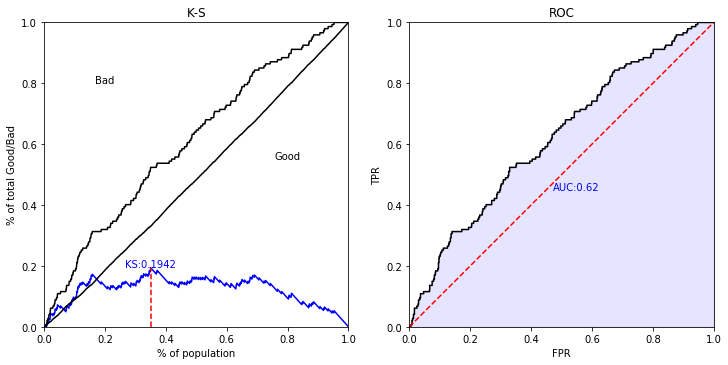

{'KS': 0.1942,
 'AUC': 0.62,
 'Gini': 0.24,
 'pic': <Figure size 864x432 with 2 Axes>}

In [523]:
sc.perf_eva(tra_y,tra_pred_y)  

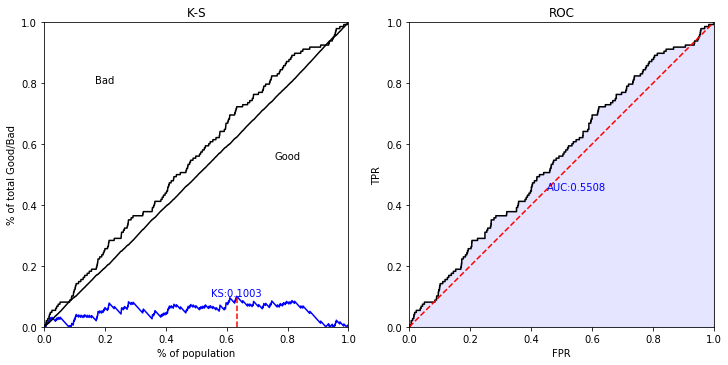

{'KS': 0.1003,
 'AUC': 0.5508,
 'Gini': 0.1017,
 'pic': <Figure size 864x432 with 2 Axes>}

In [524]:
sc.perf_eva(oot_y,oot_pred_y)                                                                                                                                   

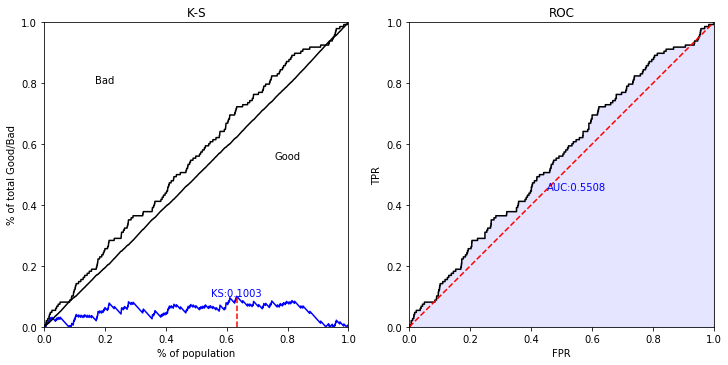

{'KS': 0.1003,
 'AUC': 0.5508,
 'Gini': 0.1017,
 'pic': <Figure size 864x432 with 2 Axes>}

In [525]:
sc.perf_eva(oot_y,oot_pred_y)  

In [586]:
m=13
r=1.5
h=1.4
sr=0.86
m*0.9-r+h

11.600000000000001